In [51]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from utils import make_dataset

import matplotlib.pyplot as plt
import numpy as np

In [86]:
from time import time

x, t = make_dataset()

ptype = tf.float32
infos = {}
times = {}
lr = 0.01
tries = 10

# for lr in [0.1, 0.03, 0.01]:
#     print(lr)
#     for ptype in [tf.float32, tf.bfloat16]:
#         print(ptype)

for hns in [2, 4, 8, 16]:
    print(hns)
    for e in [10, 25, 50, 100, 200]:
        print(e)
        dat = None
        tm = None
        for i in range(tries):
            model = keras.Sequential([
                keras.Input(shape=(2), dtype=ptype),
                layers.Dense(hns, activation=keras.activations.relu, dtype=ptype),
                layers.Dense(1, activation=keras.activations.sigmoid, dtype=ptype),
            ])

            optimizer = keras.optimizers.RMSprop(learning_rate=lr)
            model.compile(loss=keras.losses.mean_squared_error,
                          optimizer=optimizer,
                          metrics=[keras.metrics.binary_accuracy])

            ti = time()
            info = model.fit(x, t, epochs=e, verbose=0)
            print('Loss: {}, Accuracy: {}'.format(info.history['loss'][-1], info.history['binary_accuracy'][-1]))
            ti = (time() - ti) * 1e3
            
            if i == 0:
                dat = np.array(info.history['binary_accuracy'])
                tm = ti
            else:
                dat += np.array(info.history['binary_accuracy'])
                tm += ti
            
            if hns not in infos:
                infos[hns] = {}
                times[hns] = {}
            if e not in infos[hns]:
                infos[hns][e] = 0.
                times[hns][e] = 0.

            if i == tries - 1:
                infos[hns][e] = np.append(infos[hns][e], dat / tries)
                times[hns][e] = np.append(times[hns][e], tm / tries)

            model = None

2
10
Loss: 0.24872708320617676, Accuracy: 0.5
Loss: 0.25, Accuracy: 0.5
Loss: 0.25002679228782654, Accuracy: 0.5
Loss: 0.24647879600524902, Accuracy: 0.5
Loss: 0.22432224452495575, Accuracy: 0.75
Loss: 0.24587374925613403, Accuracy: 0.5
Loss: 0.2508646547794342, Accuracy: 0.5
Loss: 0.2503543496131897, Accuracy: 0.5
Loss: 0.241477370262146, Accuracy: 0.5
Loss: 0.25, Accuracy: 0.5
25
Loss: 0.2025778740644455, Accuracy: 1.0
Loss: 0.2341528832912445, Accuracy: 0.5
Loss: 0.2017982304096222, Accuracy: 0.75
Loss: 0.22973830997943878, Accuracy: 0.75
Loss: 0.2500026524066925, Accuracy: 0.5
Loss: 0.2331860363483429, Accuracy: 0.75
Loss: 0.15308047831058502, Accuracy: 1.0
Loss: 0.1778659075498581, Accuracy: 0.75
Loss: 0.2517130374908447, Accuracy: 0.5
Loss: 0.22475627064704895, Accuracy: 1.0
50
Loss: 0.17443439364433289, Accuracy: 0.75
Loss: 0.25008925795555115, Accuracy: 0.5
Loss: 0.21223333477973938, Accuracy: 0.75
Loss: 0.21077653765678406, Accuracy: 0.75
Loss: 0.17908728122711182, Accuracy: 0

Loss: 0.04369011148810387, Accuracy: 1.0
Loss: 0.00013188768934924155, Accuracy: 1.0


In [98]:
{ a: sum([max(d) for c,d in b.items()]) / len(b) for a,b in infos.items()}

{2: 0.7249999999999999,
 4: 0.7849999999999999,
 8: 0.905,
 16: 0.9800000000000001}

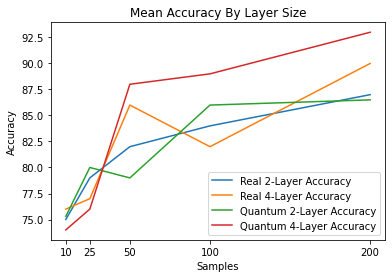

In [107]:
def plot_graphs(epochs, accuracies, legends):
    for legend in legends:
        plt.plot(epochs, accuracies)
        plt.title('Accuracies')
        plt.legend(['{} Accuracy'.format(legend)])
        plt.savefig('{}_Accuracies.png'.format(legend))
        plt.show()

z = {
    'Real 2': {10: [75], 25: [79], 50: [82], 100: [84], 200: [87]},
    'Real 4': {10: [76], 25: [77], 50: [86], 100: [82], 200: [90]},
    'Quantum 2': {10: [75.3], 25: [80], 50: [79], 100: [86], 200: [86.5]},
    'Quantum 4': {10: [74], 25: [76], 50: [88], 100: [89], 200: [93]},
}

for a, b in z.items():
    ys = []
    xs = []
    for c, d in b.items():
        m = max(d)
        ys.append(m)
        xs.append(c)
    plt.plot(xs, ys)
    plt.xticks(xs)
    plt.title('Mean Accuracy By Layer Size')
    plt.xlabel('Samples')
    plt.ylabel('Accuracy')
    plt.legend(['{}-Layer Accuracy'.format(l) for l in z.keys()])
plt.savefig('{}_Accuracy_By_Layer_Size.png'.format(a.split(' ')[0]))
plt.show()

In [125]:
np.mean([ c[0] for c in z['Quantum 4'].values() ])

84.0

In [129]:
x_ = x
# x_ = np.concatenate([x, x[:,0].reshape(4, 1) + x[:,1].reshape(4, 1), x[:,0].reshape(4, 1) + 1, x[:,1].reshape(4, 1) + 1], axis=-1)
# x_ = np.concatenate([x_, x_[:,-1].reshape(4, 1) + x_[:,-2].reshape(4, 1)], axis=-1)
# x_ = np.concatenate([x_, t.reshape(4, 1)], axis=-1)
# (x[:,0] + x[:,1]).reshape((4, 1))
x_
dtype = tf.float32
model = keras.Sequential([
    keras.Input(shape=(x_.shape[1]), dtype=ptype),
    layers.Dense(4, activation=keras.activations.sigmoid, dtype=ptype),
    layers.Dense(1, activation=keras.activations.sigmoid, dtype=ptype),
])

optimizer = keras.optimizers.RMSprop(learning_rate=lr)
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=optimizer,
              metrics=[keras.metrics.binary_accuracy])

model.summary()

# info = model.fit(x_, t, epochs=1000, verbose=0)
# print('Loss: {}, Accuracy: {}'.format(info.history['loss'][-1], info.history['binary_accuracy'][-1]))
# # model = None

Model: "sequential_1470"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2940 (Dense)           (None, 4)                 12        
_________________________________________________________________
dense_2941 (Dense)           (None, 1)                 5         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x[:,1].reshape((4, 1))

In [ ]:
x, t = make_dataset()
x.shape, t.shape
info = model.fit(x, t, epochs=1000, verbose=0)
print('Loss: {}, Accuracy: {}'.format(info.history['loss'][-1], info.history['binary_accuracy'][-1]))

In [ ]:
x, model(x)

In [ ]:
bfloat16 = tf.bfloat16.as_numpy_dtype
float16 = tf.float16.as_numpy_dtype

w = model.get_weights()
a = 1e4
w[0] = a * np.array([[1,  -1], [-1,   1]])
w[1] = a * np.array([-.5, -.5])
w[2] = a * np.array([[1], [1]])
w[3] = a * np.array([-.5])
w = [ w_i.astype(bfloat16) for w_i in w ]
w
# model.set_weights(w)
# model.weights

In [ ]:
model.get_weights()

In [ ]:
model.weights